In [1]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt


In [2]:
data = pd.read_csv('SFlow_Data_1.csv.csv', index_col=False, names=['type', 'flow_agent_addr',
                                                                   'inputPort', 'outputPort', 'src_MAC', 'dst_MAC',
                                                                   'eth_type',
                                                                   'in_vlan', 'out_vlan',
                                                                   'src_IP', 'dst_IP', 'IP_Protocol', 'ip_tos',
                                                                   'ip_ttl', 'src_port',
                                                                   'dst_port',
                                                                   'tcp_flags', 'packet_size', 'IP_size',
                                                                   'sampling_rate'])

/var/folders/4m/x6crd0n5627cn6vkx8q8s61w0000gn/T/ipykernel_38416/1197456082.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv('SFlow_Data_1.csv.csv', index_col=False, names=['type', 'flow_agent_addr',


## Top 5 Talker

In [3]:
top5talker_ip = data['src_IP'].value_counts()[:5]
print('Top 5 Talkers (IP):')
print(top5talker_ip)
print('\n')

Top 5 Talkers (IP):
193.62.192.8     3041
155.69.160.32    2975
130.14.250.11    2604
14.139.196.58    2452
140.112.8.139    2056
Name: src_IP, dtype: int64




## Top 5 Listener

In [4]:
top5_listener = data['dst_IP'].value_counts()[:5]
print('Top 5 Listeners (IP):')
print(top5_listener)

Top 5 Listeners (IP):
103.37.198.100     3841
137.132.228.15     3715
202.21.159.244     2446
192.101.107.153    2368
103.21.126.2       2056
Name: dst_IP, dtype: int64


In [5]:
top5_app = data['dst_port'].value_counts()[:5]
print('Top 5 Application Protocols:')
print(top5_app)
print('\n')

Top 5 Application Protocols:
443      13423
80        2647
52866     2068
45512     1356
56152     1341
Name: dst_port, dtype: int64




## Total Traffic

In [6]:
t_traffic = data['IP_size'].sum()
print('Total traffic: {} bytes\n'.format(t_traffic))

Total traffic: 64777822 bytes



## Proportion of TCP / UDP in Percentage 

In [7]:
print('Proportion of TCP and UDP')
udp = data['IP_Protocol'].value_counts()[6]
tcp = data['IP_Protocol'].value_counts()[17]
ip_sum = data['IP_Protocol'].sum()
udpper = udp / ip_sum * 100
tcpper = tcp / ip_sum * 100
print(ip_sum)
print('UDP(6):', udp)
print(round(udpper,2),"%")
print('TCP(17):', tcp)
print(round(tcpper,2),"%")
print('\n')

other = ip_sum - udp - tcp
otherper = other/ip_sum *100
print('Other:', other)
print(round(otherper,2), "%")

Proportion of TCP and UDP
634835
UDP(6): 56064
8.83 %
TCP(17): 9462
1.49 %


Other: 569309
89.68 %


In [8]:
pairs = {}
for index, row in data.iterrows():
    word1 = row['src_IP'] + '/' + row['dst_IP']
    word2 = row['dst_IP'] + '/' + row['src_IP']
    if word1 in pairs.keys():
        pairs[word1] += 1
    elif word2 in pairs.keys():
        pairs[word2] += 1
    else:
        pairs[word1] = 1

pairs_sorted = sorted([(k, v) for k, v in pairs.items()], key=lambda x: x[1], reverse=True)

print('Top 5 communication pairs:\n{}\n'.format(pairs_sorted[:5]))

Top 5 communication pairs:
[('137.132.228.15/193.62.192.8', 4951), ('130.14.250.11/103.37.198.100', 2842), ('14.139.196.58/192.101.107.153', 2368), ('140.112.8.139/103.21.126.2', 2056), ('140.90.101.61/167.205.52.8', 1752)]



Network visualised:



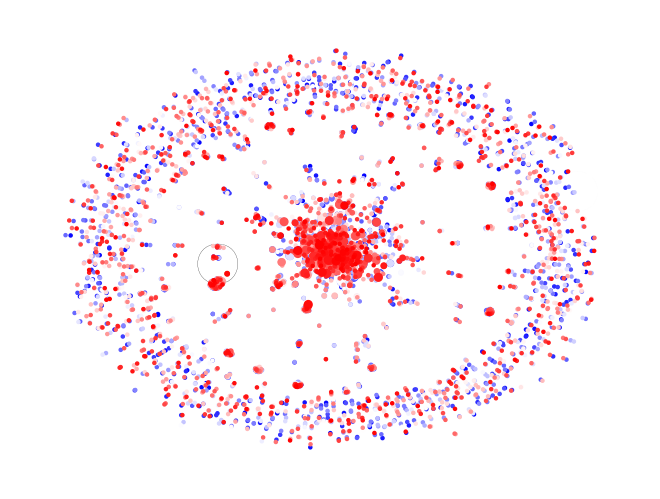

In [9]:
G = nx.Graph()
nodes = list(set(data['src_IP'].tolist()+data['dst_IP'].tolist())) #creating nodes
G.add_nodes_from(nodes)
for (p,n) in pairs_sorted:
    G.add_edge(p.split('/')[0], p.split('/')[1], weight=n)
size = []
for node in nodes:
    if G.degree(node, weight='weight')<25:
        #color.append('g')
        size.append(5)
    elif G.degree(node, weight='weight')<50:
        #color.append('b')
        size.append(10)
    elif G.degree(node, weight='weight')<75:
        #color.append('c')
        size.append(15)
    elif G.degree(node, weight='weight')<100:
        #color.append('y')
        size.append(20)
    elif G.degree(node, weight='weight')<125:
        #color.append('m')
        size.append(25)
    else:
        #color.append('r')
        size.append(30)
edges = G.edges()
weights = [G[u][v]['weight']/500 for u,v in edges]
print('Network visualised:\n')
nx.draw_spring(G, node_size=size, node_color=range(len(nodes)), width=weights, cmap=plt.cm.bwr)

## Node Visualization

In [10]:
import requests
import ipaddress

In [11]:
ip = data.loc[:, ('src_IP','dst_IP')]
print(len(ip))

ips = list(set(ip['src_IP'].tolist()+ip['dst_IP'].tolist()))
print(len(ips))

valid_ips = []
for ip in ips:
    try:
        ipaddress.ip_address(ip)
        valid_ips.append(ip)
    except:
        pass
print(len(valid_ips))

69370
5929
4777


In [12]:
## Batch IP-Geoloc
res = requests.post("http://ip-api.com/batch",json=ips[:100]).json()
res = pd.DataFrame(res)

d={}
for index, row in res.iterrows():
    d[res.at[index,'query']] = [res.at[index,'lat'],res.at[index,'lon'],res.at[index,'org'],res.at[index,'countryCode']]

res = requests.post("http://ip-api.com/batch",json=ips[100:200]).json()
res = pd.DataFrame(res)


for index, row in res.iterrows():
    d[res.at[index,'query']] = [res.at[index,'lat'],res.at[index,'lon'],res.at[index,'org'],res.at[index,'countryCode']]
    

res = requests.post("http://ip-api.com/batch",json=ips[200:300]).json()
res = pd.DataFrame(res)


for index, row in res.iterrows():
    d[res.at[index,'query']] = [res.at[index,'lat'],res.at[index,'lon'],res.at[index,'org'],res.at[index,'countryCode']]
    
res = requests.post("http://ip-api.com/batch",json=ips[300:400]).json()
res = pd.DataFrame(res)


for index, row in res.iterrows():
    d[res.at[index,'query']] = [res.at[index,'lat'],res.at[index,'lon'],res.at[index,'org'],res.at[index,'countryCode']]

res = requests.post("http://ip-api.com/batch",json=ips[400:500]).json()
res = pd.DataFrame(res)


for index, row in res.iterrows():
    d[res.at[index,'query']] = [res.at[index,'lat'],res.at[index,'lon'],res.at[index,'org'],res.at[index,'countryCode']]


In [13]:
for index, row in res.iterrows():
    d[res.at[index,'query']] = [res.at[index,'lat'],res.at[index,'lon'],res.at[index,'org'],res.at[index,'countryCode']]
print(len(d))

500


In [17]:
from pyvis.network import Network
G = nx.Graph()
ips = d.keys()
nodes = list(set(data['src_IP'].tolist()+data['dst_IP'].tolist())) #unique ips
for node in nodes:
    if node in ips:
        G.add_node(node,label=d[node][2],countryCode=d[node][3]) #add node, id=ip, label=org name

for (p,n) in pairs_sorted:
    G.add_edge(p.split('/')[0], p.split('/')[1], weight=n)

nt = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', notebook=True)
nt.from_nx(G)

## access out of notebook browser for less laggy exp
nt.show('network.html')


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [15]:
df3 = pd.DataFrame.from_dict(data=d, orient='index', columns=['lat','lng','org','cc'])
df3.index.name = 'ip'
df3

,lat,lng,org,cc
ip,,,,
202.90.128.91,14.66060,121.0514,Advanced Science and Technology Institute,PH
86888188,NaN,NaN,NaN,NaN
209.85.229.215,37.42200,-122.0840,Google LLC,US
111.221.29.106,22.26700,114.1880,Microsoft Azure Cloud (eastasia),HK
59.66.118.28,39.99970,116.3260,,CN
...,...,...,...,...
54.230.151.38,1.35208,103.8200,AWS CloudFront (GLOBAL),SG
144.89.1.153,42.56490,-89.0843,Board of Trustees of Beloit College,US
122.11.129.33,1.32429,103.8930,Starhub Internet Pte Ltd,SG


In [16]:
item_counts = df3["cc"].value_counts(normalize=False)
print(item_counts)

SG    165
US     84
TW     19
CN     16
MY     16
IN     15
JP     13
CA      9
GB      9
NL      9
HK      8
DE      7
FR      5
BR      3
AU      3
ID      3
LK      2
KR      2
SE      1
IE      1
CL      1
RU      1
PH      1
CM      1
TH      1
SA      1
BE      1
PK      1
DK      1
Name: cc, dtype: int64


Based on Dataset , Network Traffic are arranged in descending order, with SG(TOP) -- followed by US, IN, MY, TW